# Tree Field Survey: Key Statistical Insights

This notebook summarises the main statistical insights from the field survey (`field_survey.geojson`) that underpins the ALS–based PointNet training. All figures referenced below are generated by `eda/eda.py` and saved in `eda/figures/`.

The focus is on:

- Species composition and diversity
- Size structure (height and diameter) within and between species
- Age–height relationships (growth patterns)
- Correlations among tree attributes
- Spatial distribution of species across plots


In [ ]:
import sys
from pathlib import Path

import geopandas as gpd

geojson_path = str(cfg.dataset.data_dir / "field_survey.geojson")
gdf = gpd.read_file("../data/raw/field_survey.geojson")
gdf.head()

,plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
0,1.0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,None,POINT (547075.84 6450425.243)
1,1.0,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,None,POINT (547074.299 6450419.542)
2,1.0,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,None,POINT (547077.454 6450419.994)
3,1.0,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,None,POINT (547078.211 6450419.02)
4,1.0,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,None,POINT (547074.669 6450415.573)


## 1. Species Composition

The figure below shows the frequency of each tree species in the field survey.

![Species counts](figures/species_counts.png)

**Insights**

- The species distribution is clearly **imbalanced**: conifers such as Spruce and Fir and broadleaves like Birch and Aspen dominate the inventory, while species such as Elm, Willow and Tilia are comparatively rare.
- Spruce is the **single most frequent species**, accounting for roughly one third of all trees. Birch and Aspen form the next most prevalent groups.
- Minority species (e.g. Elm, Willow, Tilia) provide useful diversity but will be statistically under‑represented in model fitting. For classification with PointNet, this motivates:
  - using class‑balanced sampling or loss weighting during training;
  - monitoring per‑class accuracy rather than overall accuracy alone.
  - also for further analysis confusion matrix, F1-score and ROC curves can be used for better measure of per-class accuracy


## 2. Height Distribution

The next figure summarises the height distribution of tree height across all species.

![Height histogram](figures/height_histogram.png)

**Insights**

- Heights span roughly **10–35m**, with a concentration around the low to mid‑20s. This is consistent with mature boreal / temperate stands rather than very young plantations.
- The distribution is unimodal with right tail (skewed right): meaning extremely tall tree samples are rare in this dataset. This affects how the model will see the regression or discriminative signal from height:
  - most samples lie in a relatively narrow band where species overlap strongly;
  - extreme heights will be influential but are few in number, so they should be handled carefully when assessing model performance.
- There is no evidence of severe measurement artefacts (e.g. negative heights or multiple disjoint modes), which supports treating height as a reliable predictor for further analytics.


## 3. Height by Species

The following boxplot compares height distributions by species and highlights between‑species differences.

![Height boxplot by species](figures/height_boxplot_by_species.png)

**Insights**

- Species differ not only in prevalence but also in typical height:
  - Spruce and Aspen tend to occupy the upper range of heights, with medians in the mid‑20s and frequent individuals above 30m.
  - Birch and Fir form an intermediate group.
  - Elm, Pine and Willow typically remain shorter, with medians closer to 15–20m.
- Within‑species variability is substantial for the dominant species, indicating that local site conditions and stand age are still important modifiers of height.
- For modelling, this implies that height is informative but not sufficient to identify species: the distributions overlap, particularly in the 18–25m range. ALS‑derived structural features (crown shape, vertical distribution) and context (neighbourhood species mix) will likely add predictive power.
- Lastly, there is insufficient data to perform any EDA on less common species such as Elm, Pine and Willow in terms of their IQR (inter-quartile range). For example Elm and Pine have only one sample count and IQR requires at least 4 data points to calculate the 25th percentile (Q1), median, and 75th percentile (Q3). The IQR requires at least 4 data points to calculate the 25th percentile (Q1), median, and 75th percentile (Q3). For these rare species, only the median or individual points are displayed, reflecting the severe class imbalance in the dataset.


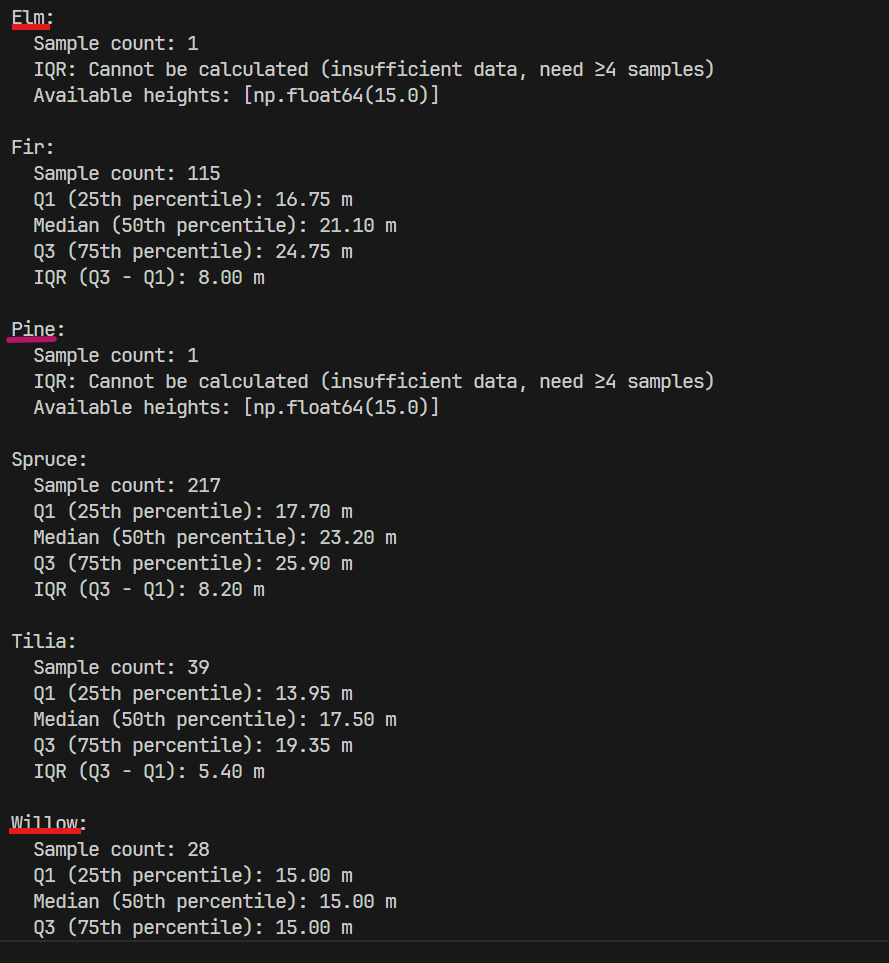

## 4. Age–Height Relationships

The scatter plot below visualises the relationship between tree age and height, stratified by species.

![Age vs height by species](figures/age_vs_height_by_species.png)

**Insights**

- Across all species there is a positive association between age and height: older trees tend to be taller, as expected.
- Age values appear in distinct bands (e.g. around 70–80 years and a younger cohort). This introduces discrete age groups rather than a continuous age spectrum. All trees in the same stand get the same or similar age. Consequently, age is more of a rough indicator, not a precise predictor. With age alone you cannot distinguish faster-growing vs. slower-growing trees within the same age band
- At a given age, different species show systematic differences in height (e.g. Spruce and Aspen often taller than Pine or Willow), which confirms that species‑specific growth curves are present.
- The substantial vertical scatter at any fixed age indicates that age alone explains only part of the height variance. Site quality, competition, and silvicultural history likely contribute substantially and will be indirectly encoded in the ALS point clouds.


## 5. Correlation Structure of Numeric Attributes

The correlation matrix below summarises linear relationships among the main numeric variables (`d1`, `d2`, `dbh`, `age`, `height`, `angle`, etc.).

![Correlation matrix](figures/correlation_matrix.png)

**Insights**

- There is a strong positive correlation block among `d1`, `d2`, `dbh` and `height`. This reflects classic tree allometry: thicker stems and larger diameters are associated with greater height.
- Age shows moderate positive correlations with both height and diameter measures, consistent with the age–height plot above.
- Plot identifiers and tree numbers have weak or negligible correlations with structural variables (like height and diameter), indicating that they primarily encode location rather than biophysical properties.
- Leaning angle exhibits little linear association with size or age, suggesting that stem inclination is driven more by local mechanical factors (wind, competition) than by tree size alone.
- Looking for feature redundnacy, this block structure (i.e. d1, d2, dbh, height) implies that diameter‑related covariates are partially redundant because including all of them does not add any new information nor insight. In ALS‑derived features, similar redundancy will occur between multiple height metrics (e.g. mean canopy height, 95th percentile, maximum height), so dimension‑reducing encoders such as PointNet’s shared MLPs are well‑suited (see MODEL_CHOICES.md). In future, removing redundant features such as PCA would be ideal prior to EDA stage


## 6. Spatial Distribution of Species

The final figure shows the spatial arrangement of plots and the species mixture within each plot.

![Species spatial distribution](figures/species_spatial_distribution.png)

**Insights**

- The inventory consists of a set of rectangular plots scattered across the landscape, each containing a mixture of species.
- Some plots appear dominated by a single species (e.g. conifer‑rich stands), while others show a more mixed composition with several broadleaf and conifer species co‑occurring.
- The geographic spread of plots implies that the dataset samples a range of site conditions. When combined with ALS, this supports learning species–structure relationships that are not tied to a single stand.
- For model evaluation, spatial information is crucial: splitting data purely at the tree level risks leakages between nearby plots. Defining train/validation sets at the plot level (or even at higher spatial units) will provide a more realistic assessment of generalisation to new areas.


## 7. Implications for PointNet Training

+
Based on the above, the main implications for the PointNet/PointNet++ pipeline are:

1. **Class imbalance**: dominant species (Spruce, Birch, Aspen) will tend to drive the loss. Class‑balanced sampling in datapreprocessor.py or class‑weighted cross‑entropy in trainer.py can mitigate this and improve minority‑class performance.
2. **Overlapping height distributions**: since heights overlap strongly between species, the network must rely on 3D structural cues (crown shape, vertical distribution of points) rather than height alone. Height variable alone is not sufficient to distinguish between species
3. **Age bands and stand structure**: discrete age cohorts and strong within‑cohort variability suggest that ALS‑derived texture and canopy structure could capture aspects of stand development that age alone does not fully encode.
4. **Correlated size metrics**: heavy correlations among diameter and height measures mean that using many highly collinear scalar features adds limited information. The ALS point clouds naturally capture this structure, allowing the PointNet encoder to learn compact internal representations.
5. **Spatial generalisation**: given the spatial clustering of plots, it is statistically safer to define validation splits at the plot or region level when assessing model performance. This reduces the risk of over‑optimistic results due to spatial autocorrelation between training and validation trees which breaks the i.i.d assumption in ML.

Together, these insights support the current pipeline design: per‑tree ALS patches, a balanced sampling strategy, and a PointNet‑style encoder that can exploit detailed 3D structure beyond simple height or diameter thresholds.


# Future Steps

* For future work, to account for class imbalance, it would be great to consider using F-1 score to evaluate the model, as well as ROC curve to visualize the segmentation performance of the model hollistically on all categories of tree species.
* More information regarding capturing canopy texture and structure that indirectly encode these factors can be explored to improve model accuracy and robustness.
* Variables like diameter (d1, d2, dbh) and height are strongly correlated (see Correlation matrix above). Adding many similar scalar features does not add much new information. Traditional models can suffer from feature redundancy, therefore manual feature selection would be required.
* Getting the analytical part in modelling will have down knocking effect in say for example 3D game level building in a forest like environment as it will effect ecological realism of outputs. This will help differentiate high-level design impact to concrete gameplay/art implications. All of which are practical ML choices affecting downstream systems in generative level design.